In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Imports and setup

from __future__ import annotations
from pathlib import Path
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, List
import re, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


[env] Matplotlib backend: module://matplotlib_inline.backend_inline


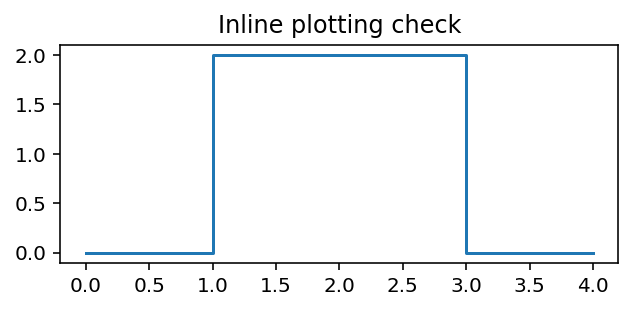

In [2]:
# Diagnostics — check inline rendering

import matplotlib
print("[env] Matplotlib backend:", matplotlib.get_backend())
plt.figure(figsize=(5,2))
x = [0, 1, 2, 3, 4]
y = [0, 0, 2, 2, 0] 
plt.step(x, y)
plt.title("Inline plotting check")
plt.show()

# Executive Summary

We use an **Ornstein–Uhlenbeck (OU) fit** to generate the **mean** and **entry/exit bands** for forward-rate factors. Each factor (e.g. **SLOPE**, **CURVATURE**) is modeled as a mean-reverting OU process:
$$
dX_t = \kappa (\theta - X_t)\,dt + \sigma\,dW_t
$$

where:
$\theta$ — long-run equilibrium (OU mean), $\kappa$ — mean-reversion speed, and $\sigma$ — instantaneous volatility.  
After fitting this model on a historical window, we estimate:
$
\kappa = -\frac{\ln b}{\Delta t}, 
\theta = \frac{a}{1-b}, 
\sigma = \sqrt{\frac{2\kappa\,\text{Var}(\varepsilon_t)}{1-b^2}}
$
from the discrete regression:
$$
X_{t+1} = a + bX_t + \varepsilon_t
$$
The OU mean $\theta$ acts as a **gravitational center**.  When a factor deviates too far from it, the model assumes mean reversion will occur —  these deviations trigger **entry** and **exit** signals in the trading logic.

For this analysis:

- **2017** illustrates a *trending regime* where the OU assumption breaks down (weak fit, poor reversions).  
- **2023** illustrates a *mean-reverting regime* where the OU fit holds, leading to smoother oscillations and better performance.


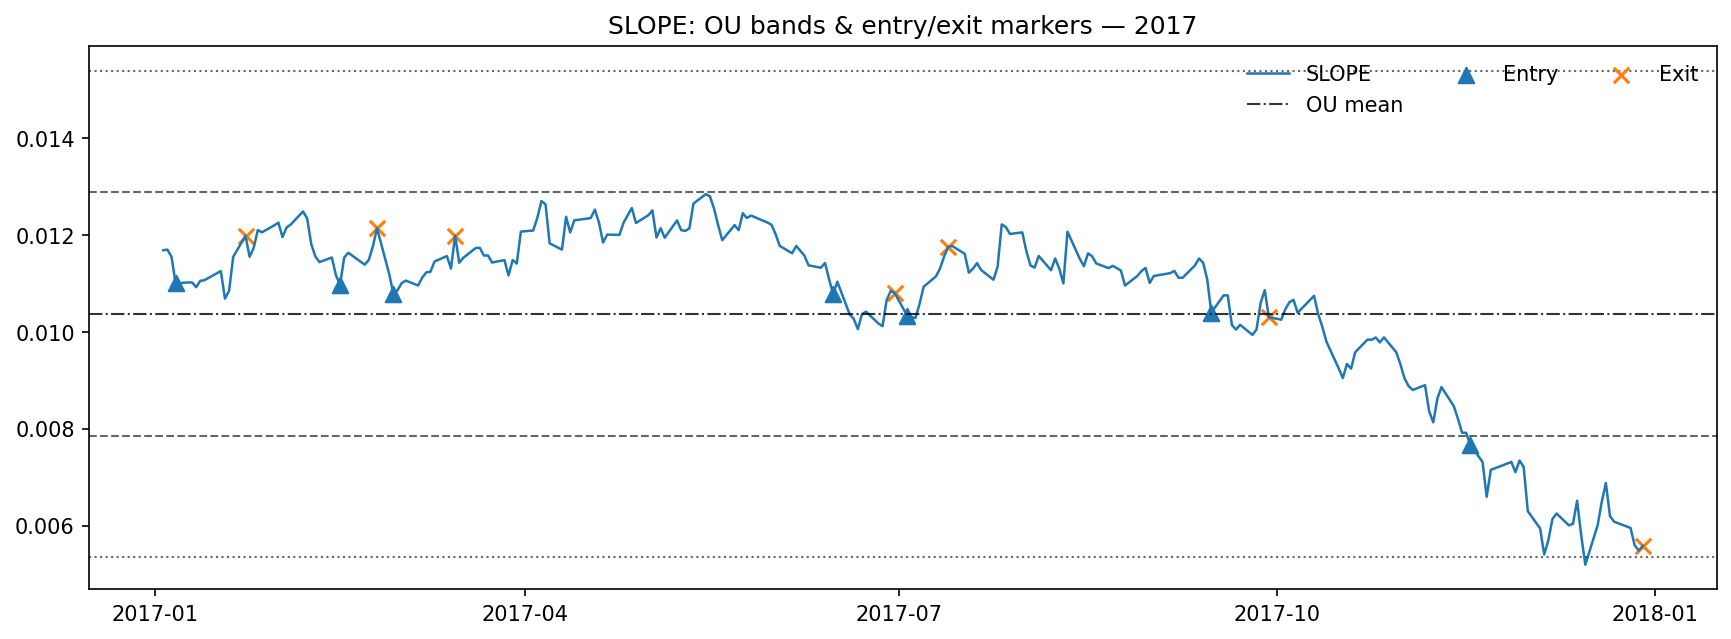

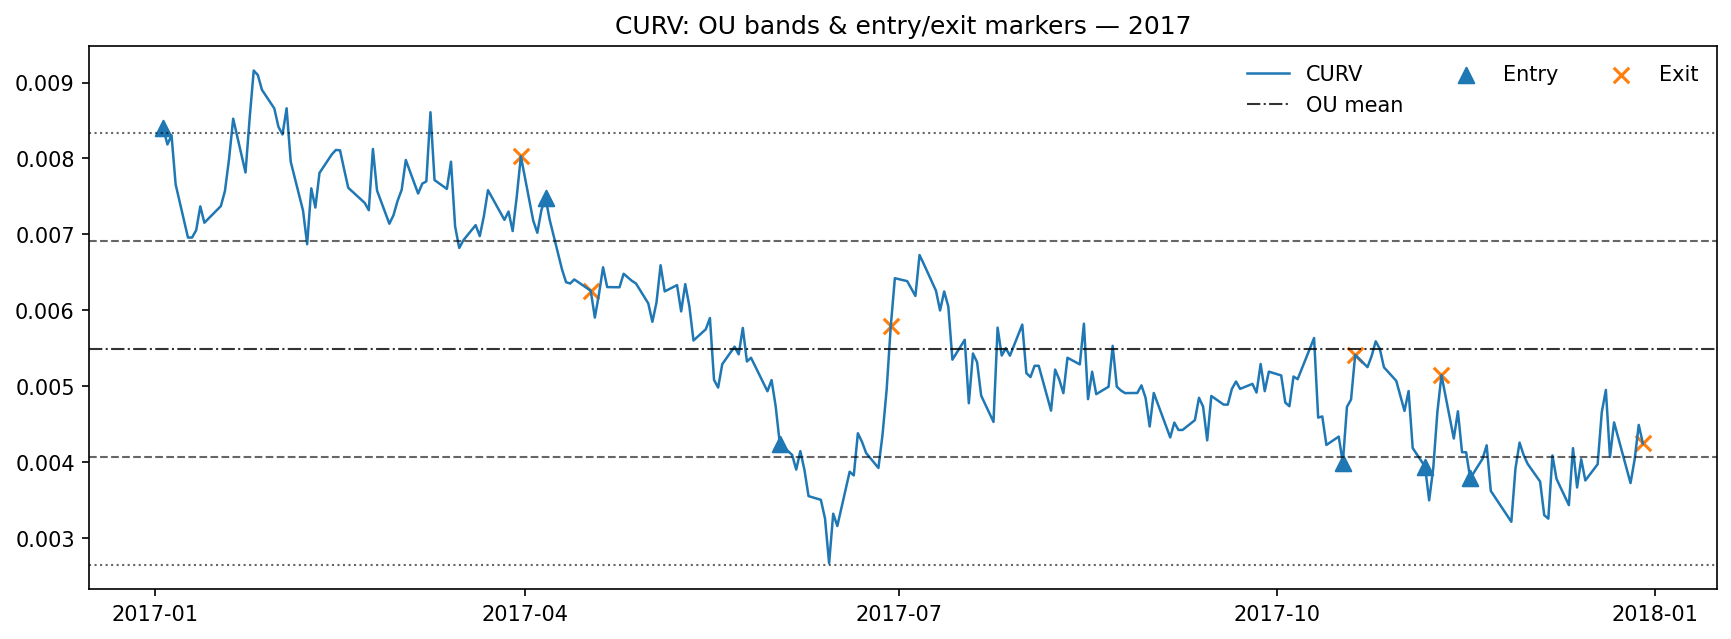

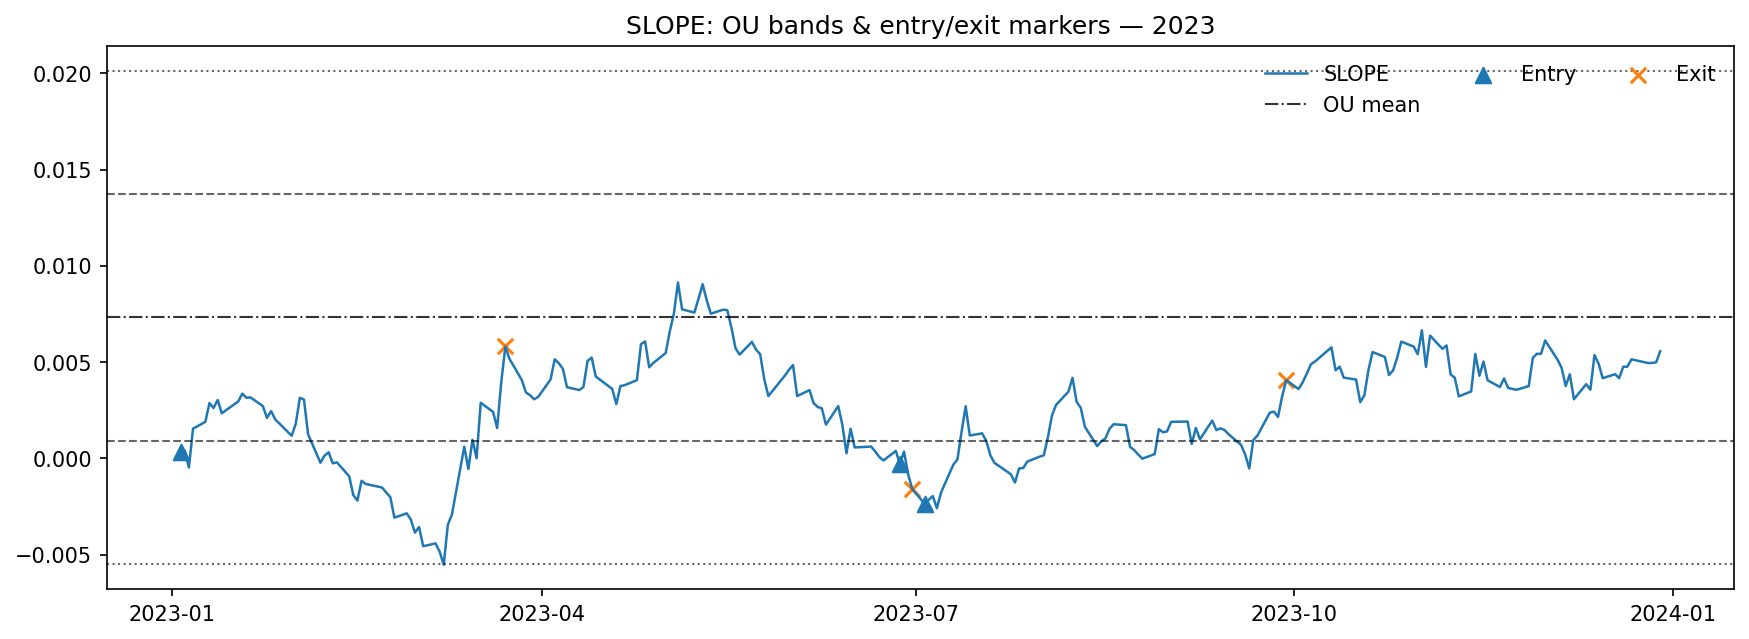

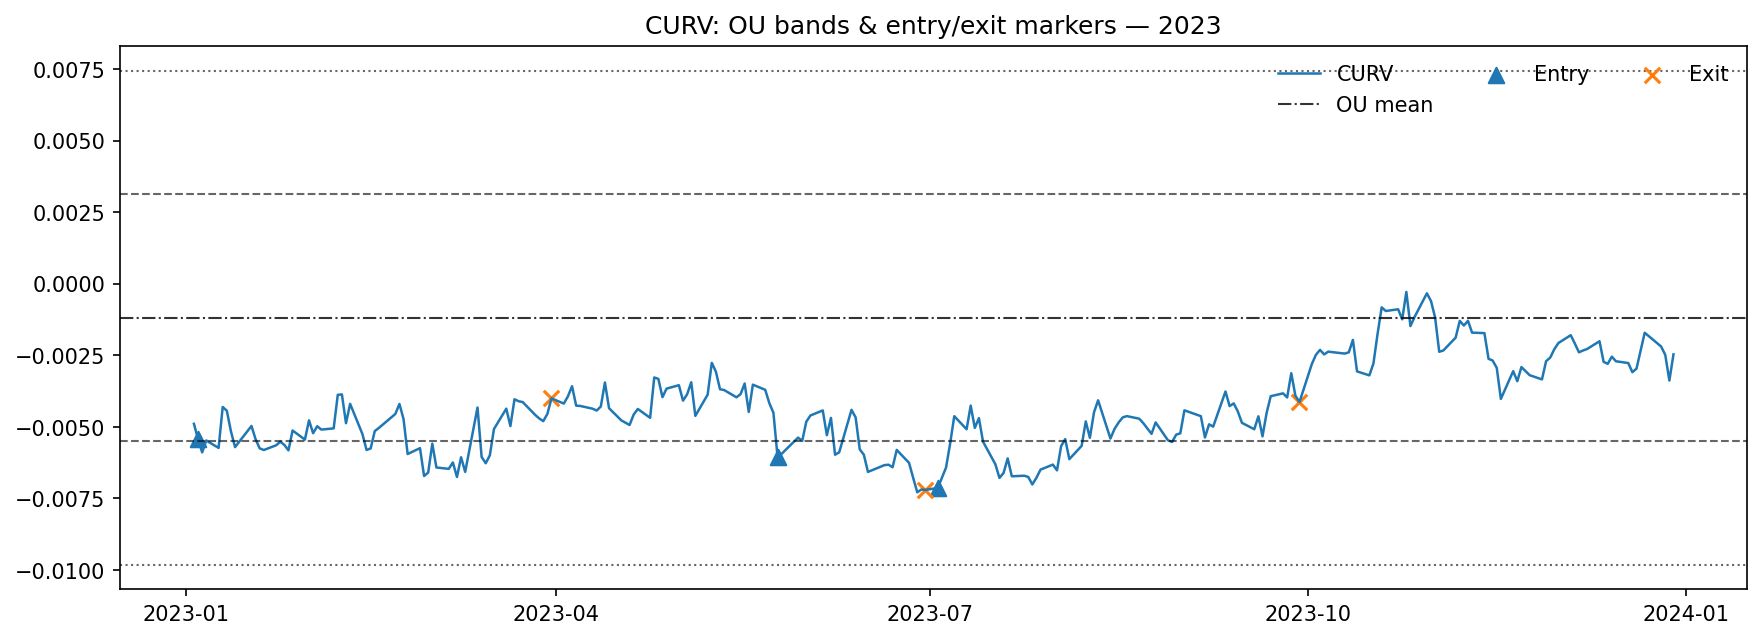

In [3]:
from IPython.display import Image, display

# Display saved figures without recomputation
for year in [2017, 2023]:
    for factor in ["SLOPE", "CURV"]:
        fname = f"fig_{year}_{factor}.png"
        display(Image(filename=fname))


### Note:

- **Blue line:** realized factor time series (SLOPE or CURV).  
- **Dash-dot black line:** OU mean $\theta$ — the model’s equilibrium level.  
- **Gray dashed lines:** mean ± threshold bands, given by $\theta \pm z_{\text{in/out}}\,s_{\text{stat}}$, where $s_{\text{stat}} = \sigma / \sqrt{2\kappa}$ is the stationary standard deviation.  
- **▲ Entry / ✕ Exit markers:** trades triggered when the z-score crosses the chosen thresholds.  

In [4]:
# User knobs

ROOT = Path(".")
IFWDS_NAME = "daily_UST_IFwds.csv"
YEARS = [2017, 2023]

from dataclasses import dataclass
from typing import Tuple

@dataclass
class EEConfig:
    year: int
    lookback_years: int = 5
    c_in_bps: float = 0.20
    c_out_bps: float = 0.20

    # === speed knobs ===
    speed_mode: bool = True          # True = skip grid search; use fixed bands
    fixed_z_in: float = 1.0          # used when speed_mode is True
    fixed_z_out: float = 0.3         # used when speed_mode is True
    refit_freq: str = "Q"            # "M" (monthly) or "Q" (quarterly)
    use_carry_overlay: bool = False  # carry can be expensive
    allow_flip: bool = True
    carry_h_bd: int = 21

    # grid, only used if speed_mode=False
    z_in_grid: Tuple[float, float, float] = (0.8, 1.8, 0.1)
    z_out_grid: Tuple[float, float, float] = (0.1, 0.9, 0.1)


In [5]:
# Load the IFwds data

def find_file(root: Path, pattern: str) -> Path:
    hits = list(root.rglob(pattern))
    if not hits:
        raise FileNotFoundError(f"Could not find {pattern} under {root.resolve()}")
    hits.sort(key=lambda p: len(str(p)))
    return hits[0]

def keep_numeric_tenors(df: pd.DataFrame) -> pd.DataFrame:
    cols = {}
    for c in df.columns:
        s = str(c).strip()
        try:
            tau = float(s)
            cols[tau] = pd.to_numeric(df[c], errors="coerce")
            continue
        except Exception:
            pass
        m = re.search(r"(\d+(\.\d+)?)", s)
        if m:
            try:
                tau = float(m.group(1))
                cols[tau] = pd.to_numeric(df[c], errors="coerce")
            except Exception:
                pass
    if not cols:
        raise ValueError("No numeric tenor columns found in IFwds CSV.")
    out = pd.DataFrame(cols, index=df.index).dropna(axis=1, how="all")
    out = out.reindex(sorted(out.columns), axis=1)
    return out

In [6]:
# Upload data

IFWDS = find_file(ROOT, IFWDS_NAME)
print(f"[io] Using IFwds at: {IFWDS}")

F = pd.read_csv(IFWDS, index_col=0)
F.index = pd.to_datetime(F.index, errors="coerce").tz_localize(None)
F = F.dropna(how="any").sort_index()
F = keep_numeric_tenors(F)
taus = F.columns.values.astype(float)
print(f"[io] Loaded IFwds: {F.shape[0]} days, {len(taus)} tenors (min={taus.min()}, max={taus.max()})")


[io] Using IFwds at: daily_UST_IFwds.csv
[io] Loaded IFwds: 2463 days, 30 tenors (min=1.0, max=30.0)


## 1. Yield Curve Shape Factors

We start with daily forward rates $F_t(\tau)$ across maturities $\tau \in [1,30]$ years.  
From these, we extract shape factors that summarize the curve:
$$
LEVEL_t = F_t(10)  \quad
SLOPE_t = F_t(10) − F_t(2)  \quad
CURV_t  = 2F_t(5) − F_t(2) − F_t(10)
$$
where  
- LEVEL: overall height of the yield curve (average rate level).  
- SLOPE: steepness between short and long maturities (2y–10y).  
- CURVATURE: bow shape; positive when the mid-term rate (5y) is high relative to 2y and 10y.


In [7]:
def compute_shapes(F: pd.DataFrame) -> pd.DataFrame:
    taus = F.columns.values.astype(float)
    def _interp_row(row, tau):
        if tau <= taus[0]: return float(row.iloc[0])
        if tau >= taus[-1]: return float(row.iloc[-1])
        j = int(np.searchsorted(taus, tau))
        t0, t1 = taus[j-1], taus[j]
        w = (tau - t0) / (t1 - t0)
        return (1 - w) * float(row.iloc[j-1]) + w * float(row.iloc[j])
    LEVEL = F.apply(lambda r: _interp_row(r, 10.0), axis=1)
    SLOPE = F.apply(lambda r: _interp_row(r, 10.0) - _interp_row(r, 2.0), axis=1)
    CURV  = F.apply(lambda r: 2.0*_interp_row(r, 5.0) - _interp_row(r, 2.0) - _interp_row(r, 10.0), axis=1)
    return pd.DataFrame({"LEVEL": LEVEL, "SLOPE": SLOPE, "CURV": CURV}, index=F.index)

## 2. Ornstein–Uhlenbeck (OU) Process Fit

Each factor $X_t \in \{\text{LEVEL}, \text{SLOPE}, \text{CURV}\}$ is modeled as a mean-reverting process:
$
dX_t = \kappa (\theta - X_t)\,dt + \sigma\,dW_t
$

When discretized for daily data $(\Delta t = 1/252)$, it is:
$
X_{t+1} = a + b X_t + \varepsilon_t , \quad \varepsilon_t \sim \mathcal{N}(0, \sigma_\varepsilon^2)
$

Regression gives $a, b$, from which:
- $\kappa = -\frac{\ln(b)}{\Delta t}$ &nbsp;&nbsp;&nbsp;*(mean reversion speed)*  
- $\theta = \frac{a}{1 - b}$ &nbsp;&nbsp;&nbsp;*(long-term equilibrium level)*  
- $\sigma = \sqrt{\frac{2\kappa \sigma_\varepsilon^2}{1 - b^2}}$ &nbsp;&nbsp;&nbsp;*(volatility parameter)*

The stationary (long-run) standard deviation is:
$
s_{\text{stat}} = \frac{\sigma}{\sqrt{2\kappa}}
$

---
The OU process describes a “rubber-band” behavior — the factor tends to revert toward $\theta$, with stronger pull when $\kappa$ is large.


In [8]:
def fit_ou_from_series(x: pd.Series) -> Dict[str,float]:
    x = x.dropna().astype(float)
    y, z = x.iloc[1:].values, x.iloc[:-1].values
    X = np.column_stack([np.ones_like(z), z])
    beta = np.linalg.pinv(X.T @ X) @ (X.T @ y)
    a, b = float(beta[0]), float(beta[1])
    dt = 1/252
    b = np.clip(b, -0.999999, 0.999999)
    kappa = max(1e-8, -np.log(max(1e-8, b))/dt)
    theta = a / max(1e-6, 1-b)
    resid = y - (a + b*z)
    var_e = float(np.var(resid, ddof=1))
    sigma = np.sqrt(max(1e-12, var_e * 2*kappa / (1 - b**2)))
    return {"kappa":kappa,"theta":theta,"sigma":sigma}

def ou_stat_std(params: Dict[str,float]) -> float:
    return params["sigma"] / np.sqrt(2*max(params["kappa"], 1e-12))


## 3. Shape Weights  

We build **discrete shape portfolios** on the tenor grid $ \tau = [\tau_1, \dots, \tau_n] $ by placing signed weights on a few nearby maturities, then normalizing by the $\ell^1$ norm so that the total absolute exposure equals 1.

---

### a) Slope weights (10s–2s)

Approximate the 10y–2y *slope* using the available tenor grid.

1. Pick indices closest to 2y and 10y:
   $$
   i_{2} = \arg\min_j |\tau_j - 2|, \qquad
   i_{10} = \arg\min_j |\tau_j - 10|
   $$

2. Define raw weights $\tilde{w} \in \mathbb{R}^n$:
   $$
   \tilde{w}_j =
   \begin{cases}
   +1, & j = i_{10},\\
   -1, & j = i_{2},\\
   0,  & \text{otherwise}
   \end{cases}
   $$

3. Normalize by the $\ell^1$ norm:
   $$
   w = \frac{\tilde{w}}{\sum_{j=1}^n |\tilde{w}_j|}
   $$

---
This represents a *10s–2s* spread position — long the 10-year forward rate, short the 2-year, equalized in notional. The portfolio value changes roughly with $\Delta(f_{10y} - f_{2y})$.


### b) Curvature (butterfly) weights (2–5–10)

Isolate the *curvature* (“butterfly”) component — long belly (5y) vs short wings (2y, 10y).

1. Pick indices closest to 2y, 5y, 10y:
   $$
   i_{2} = \arg\min_j |\tau_j - 2|, \qquad
   i_{5} = \arg\min_j |\tau_j - 5|, \qquad
   i_{10} = \arg\min_j |\tau_j - 10|
   $$

2. Define raw weights:
   $$
   \tilde{w}_j =
   \begin{cases}
   +2, & j = i_{5},\\
   -1, & j = i_{2},\\
   -1, & j = i_{10},\\
   0,  & \text{otherwise}
   \end{cases}
   $$

3. Normalize by $\ell^1$ norm:
   $$
   w = \frac{\tilde{w}}{\sum_{j=1}^n |\tilde{w}_j|}
   $$

---  
The coefficients sum to zero, making the position *level-neutral*. It isolates curvature: profit arises when the 5y point moves differently from the ends (the 2y and 10y); hence the reason for the **+2, −1, −1**.


### c) Portfolio interpretation

Given a forward curve $f(\tau)$ sampled on the tenor grid, the weighted portfolio value is

$$
P = w^\top f
$$

and its daily change (ignoring carry) is

$$
\Delta P \approx w^\top \Delta f
$$

For slope weights, this tracks the change in the 10s–2s spread;  
for curvature weights, it measures the “bow” or bending of the curve.

---
- **Nearest-tenor selection:** choosing the grid point closest to each target maturity makes the method portable across arbitrary grids.  
- **Normalization:** $\ell^1$ normalization ($\sum |w_i| = 1$) keeps exposures comparable across shapes.  
- **Alternatives:** you could instead use DV01-neutral weights or different maturities (e.g., 3–7–10) to match a specific bond universe.


In [9]:
def slope_weights(taus: np.ndarray) -> np.ndarray:
    w = np.zeros_like(taus, dtype=float)
    i2 = np.argmin(np.abs(taus-2)); i10 = np.argmin(np.abs(taus-10))
    w[i10], w[i2] = 1.0, -1.0
    return w/np.abs(w).sum()

def curv_weights(taus: np.ndarray) -> np.ndarray:
    w = np.zeros_like(taus, dtype=float)
    i2 = np.argmin(np.abs(taus-2)); i5 = np.argmin(np.abs(taus-5)); i10 = np.argmin(np.abs(taus-10))
    w[i5], w[i2], w[i10] = 2.0, -1.0, -1.0
    return w/np.abs(w).sum()

## 4. HJM Carry Construction

We want a simple, model-consistent estimate of **carry/roll** for a shape portfolio.  
Under the Heath–Jarrow–Morton (HJM) framework (risk-neutral measure), the forward rate’s drift is its maturity derivative:

$$
\mathbb{E}[\,df_t(\tau)\,] \;=\; \frac{\partial f_t(\tau)}{\partial \tau}\,dt 
$$

---
This means: if the curve does not shock, forwards “roll” along the maturity axis at a rate given by the **convection term** $\partial f / \partial \tau$.



### a) `hjm_carry_vector` — per-tenor carry over an $H$-day horizon

Given a forward curve snapshot $f_t(\tau)$ sampled on the tenor grid $\{\tau_i\}_{i=1}^n$, we approximate the maturity derivative numerically and scale it to an $H$ business-day horizon:

1. Numerical gradient along maturity:
   $$
   \left.\frac{\partial f_t(\tau)}{\partial \tau}\right|_{\tau=\tau_i}
   \;\approx\; \mathrm{grad}_\tau f_t(\tau_i)
   $$

2. Scale from 1 year to $H$ business days (using 252 bd/year):
   $$
   c_t(\tau_i) \;=\; \frac{\partial f_t(\tau_i)}{\partial \tau} \cdot \frac{H}{252}
   $$

In vector form across all tenors:
$$
\mathbf{c}_t \;=\; \left( c_t(\tau_1), \ldots, c_t(\tau_n) \right)^\top 
$$

In [10]:
def hjm_carry_vector(f_curve: np.ndarray, taus: np.ndarray, H_bd: int = 21) -> np.ndarray:
    df_dtau = np.gradient(f_curve, taus)
    return df_dtau * (H_bd / 252.0)

### b) `daily_carry_for_weights` — a daily time series for a portfolio

We turn the above **carry vectors** into a **daily** series for a fixed weight vector $w \in \mathbb{R}^n$ (e.g., slope or curvature weights), using the following steps:


1. **Sample at month-end:** for each month-end date $M_k$, take the forward curve $f_{M_k}(\cdot)$ and compute its $H$-day carry vector
   $$
   \mathbf{c}_{M_k} \;=\; \frac{\partial f_{M_k}}{\partial \tau}\cdot \frac{H}{252}
   $$

2. **Portfolio carry at month-end:** project onto weights $w$
   $$
   C^{(w)}_{M_k} \;=\; w^\top \mathbf{c}_{M_k}
   $$

3. **Forward-fill between month-ends:** assume the carry environment stays roughly unchanged until the next month-end, so use $C^{(w)}_{M_k}$ for all trading days $t \in (M_k, M_{k+1}]$.

4. **Convert to per-day units:** since $C^{(w)}_{M_k}$ is the $H$-day carry, divide by $H$ to express a **daily** carry:
   $$
    daily_{carry}^{w_t} \;=\; \frac{C^{(w)}_{M_k}}{H} \quad\text{for } t \in (M_k, M_{k+1}
   $$

---
**In the following script, we:**
- Resample `Fsub` to month-end, loops over rows to build $\mathbf{c}_{M_k}$ via `hjm_carry_vector`,
- Compute $C^{(w)}_{M_k} = w^\top \mathbf{c}_{M_k}$,
- Build a monthly series and `ffill`s to all days, and
- Divide by $H$ to get per-day carry.

In [11]:

def daily_carry_for_weights(Fsub: pd.DataFrame, w: np.ndarray, H_bd: int = 21) -> pd.Series:
    taus = Fsub.columns.values.astype(float)
    month_end = Fsub.resample("M").last()
    carr = []
    for idx, row in month_end.iterrows():
        cvec = hjm_carry_vector(row.values.astype(float), taus, H_bd)
        carr.append((idx, float(np.dot(w, cvec))))
    carr = pd.Series(dict(carr)).reindex(month_end.index).ffill()
    return carr.reindex(Fsub.index, method="ffill") / max(H_bd, 1)

Note:
    
- The construction is **HJM-consistent** (risk-neutral drift is $\partial f/\partial \tau$), but **pragmatic**:
  - We use a finite-difference gradient along maturity,
  - We **sample once per month** and forward-fill for stability,
  - We scale using **252 bd/year**.
- If higher reactivity is required, resample weekly or daily instead of monthly but at the expense of computation time though!
- If selected securities have **DV01 heterogeneity**, consider DV01-scaled weights $w$ when computing $w^\top \mathbf{c}_t$.

## 5. Backtest Engine 

This routine simulates **path-dependent entry/exit trading** for a single factor (e.g., SLOPE or CURV) over a window $[t_0, t_1]$, using OU-based $z$-bands and optional carry.

### Given inputs
- $F_t(\tau_1),\dots,F_t(\tau_n)$: forward curve time series on a fixed tenor grid.
- $X_t$: the chosen shape series (SLOPE or CURV) extracted from $F_t$.
- OU params $\{\theta,\kappa,\sigma\}$ for $X_t$ over the lookback.
- Thresholds $z_{\text{in}}$, $z_{\text{out}}$.
- Fixed portfolio weights $w \in \mathbb{R}^n$ (slope/curv weights on the tenor grid).
- Costs $c_{\text{in}}$, $c_{\text{out}}$ (in bps PVBP).
- Optional daily carry series $\text{carry}_t$ aligned to dates in the window.
- Flip flag (allow switching directly from long to short and vice versa).

---

### a) Windowing and z-scores
Slice the date index to $t=t_0,\dots,t_1$ and compute standardized deviations
$
s_{\text{stat}} \;=\; \frac{\sigma}{\sqrt{2\kappa}}, \;
z_t \;=\; \frac{X_t - \theta}{\max(s_{\text{stat}},\varepsilon)}\,,
$
with a tiny $\varepsilon$ to guard against divide-by-zero.

---

### b) Portfolio returns and carry
Daily forward-curve changes on the grid:
$
\Delta F_t \;=\; F_t - F_{t-1} \in \mathbb{R}^n.
$

Portfolio exposure is fixed by $w$, so the **shape P\&L** from curve moves is
$
\Delta P^{(\text{shape})}_t \;=\; w^\top \Delta F_t.
$

If provided, we add a **carry** component $\text{carry}_t$ (already aligned per day):
$
\Delta P^{(\text{total})}_t \;=\; \Delta P^{(\text{shape})}_t \;+\; \text{carry}_t.
$

---

### c) Trading state machine (path-dependent)
We maintain a position $\text{side}_t \in \{-1,0,+1\}$ updated each day from the $z$-signal:

- **Flat $\to$ Long:** if $z_t \le -z_{\text{in}}$, set $\text{side}_t = +1$ and charge entry cost $c_{\text{in}}$.
- **Flat $\to$ Short:** if $z_t \ge +z_{\text{in}}$, set $\text{side}_t = -1$ and charge entry cost $c_{\text{in}}$.
- **In position — Exit:** if $|z_t| \le z_{\text{out}}$, close to flat and charge exit cost $c_{\text{out}}$.
- **In position — Flip (optional):** if allowed and the *opposite* entry band is hit, exit (charge $c_{\text{out}}$) and immediately enter on the other side (charge $c_{\text{in}}$).

Formally, with previous-day side $\text{side}_{t^-}$,
$$
\text{side}_t =
\begin{cases}
+1, & \text{if } \text{side}_{t^-}=0 \text{ and } z_t \le -z_{\text{in}},\\[2pt]
-1, & \text{if } \text{side}_{t^-}=0 \text{ and } z_t \ge +z_{\text{in}},\\[2pt]
0, & \text{if } \text{side}_{t^-}\!\ne 0 \text{ and } |z_t|\le z_{\text{out}},\\[2pt]
-\text{side}_{t^-}, & \text{if flip is allowed and opposite band is crossed},\\[2pt]
\text{side}_{t^-}, & \text{otherwise}
\end{cases}
$$

---

### d) Daily P\&L with costs
Costs are assessed *on the day* of entry/exit. Using bps PVBP units (so costs are scaled by $10^{-4}$):
$$
\text{cost}_t =
\begin{cases}
+c_{\text{in}}\cdot 10^{-4},  & \text{on entries},\\
+c_{\text{out}}\cdot 10^{-4}, & \text{on exits},\\
0, & \text{otherwise}
\end{cases}
$$
Daily P\&L:
$$
\text{PnL}_t \;=\; \text{side}_t \cdot \Delta P^{(\text{total})}_t \;-\; \text{cost}_t
$$

If a trade is still open on the last date, we **force-close** it at $t_1$ and apply $c_{\text{out}}$.

---

### e) Outputs
- **Trades table:** each row has `factor`, `entry` date/time, `exit` date/time, and `side` ($\pm 1$).
- **Daily P\&L series:** $\{\text{PnL}_t\}_{t_0}^{t_1}$, ready for aggregation (e.g., annualized mean/vol and Sharpe).

---

### Note:
- The logic is **path-dependent** (threshold crossings depend on the sequence of $z_t$).  
- Using a fixed $w$ isolates the chosen **shape** exposure; DV01-scaled $w$ can be substituted if instrument DV01s differ.  
- Costs are modeled in **bps PVBP**, consistent with fixed-income execution/roll conventions.  
- Carry can be omitted by passing a `None` series (the engine then uses zeros).


In [12]:
# Backtest engine

def backtest_thresholds_on_window(
    F: pd.DataFrame,
    shapes: pd.DataFrame,
    start: pd.Timestamp,
    end: pd.Timestamp,
    factor: str,
    ou: Dict[str, float],
    z_in: float,
    z_out: float,
    w: np.ndarray,
    c_in_bps: float,
    c_out_bps: float,
    carry_series: Optional[pd.Series] = None,
    allow_flip: bool = True,
):
    # slice once
    sub_idx = F.index[(F.index >= start) & (F.index <= end)]
    if len(sub_idx) < 3:
        return pd.DataFrame(), pd.Series(dtype=float)

    subF = F.loc[sub_idx]
    subS = shapes.loc[sub_idx, factor].astype(float).values

    # z-score series (numpy arrays)
    theta, sigma, kappa = ou["theta"], ou["sigma"], ou["kappa"]
    sstat = sigma / np.sqrt(2.0 * max(kappa, 1e-12))
    z = (subS - theta) / max(sstat, 1e-12)

    # portfolio dF + carry arrays
    dF = subF.diff().fillna(0.0).values
    port_dF = dF @ w
    if carry_series is not None:
        carry = carry_series.reindex(sub_idx).fillna(method="ffill").fillna(0.0).values
    else:
        carry = np.zeros_like(port_dF)

    # path-dependent loop in pure Python (fast; uses numpy arrays)
    side = 0
    pnl = np.zeros(len(sub_idx), dtype=float)
    trades = []
    open_entry_i = None
    open_side = 0

    for i in range(len(sub_idx)):
        zi = float(z[i])

        if side == 0:
            if zi <= -z_in:
                side = +1
                open_entry_i = i
                open_side = +1
                pnl[i] -= c_in_bps / 1e4
                trades.append({"factor": factor, "entry": sub_idx[i], "side": +1})
            elif zi >= +z_in:
                side = -1
                open_entry_i = i
                open_side = -1
                pnl[i] -= c_in_bps / 1e4
                trades.append({"factor": factor, "entry": sub_idx[i], "side": -1})
        else:
            # exit condition
            if abs(zi) <= z_out:
                pnl[i] -= c_out_bps / 1e4
                trades[-1]["exit"] = sub_idx[i]
                side = 0
                open_entry_i = None
                open_side = 0
            # flip condition
            elif allow_flip and ((side == +1 and zi >= +z_in) or (side == -1 and zi <= -z_in)):
                pnl[i] -= c_out_bps / 1e4
                trades[-1]["exit"] = sub_idx[i]
                side = -side
                open_side = side
                pnl[i] -= c_in_bps / 1e4
                trades.append({"factor": factor, "entry": sub_idx[i], "side": side})

        # running PnL
        pnl[i] += side * (port_dF[i] + carry[i])

    # force-close open trade at window end
    if trades and "exit" not in trades[-1]:
        trades[-1]["exit"] = sub_idx[-1]
        pnl[-1] -= c_out_bps / 1e4

    trades_df = pd.DataFrame(trades)
    pnl_s = pd.Series(pnl, index=sub_idx)
    return trades_df, pnl_s


## 6. Choosing Monthly Entry/Exit Bands

The next script selects a pair of OU $z$-score thresholds $(z_{\text{in}}, z_{\text{out}})$ at a rebalancing date (e.g., month-end), using a rolling lookback. It supports a **fast path** (fixed bands) and a **slow path** (grid search to maximize Sharpe).

### Given inputs
- Forward curves $F_t(\tau)$ and a derived **shape** series $X_t$ (e.g., SLOPE or CURV) in `shapes`.
- Rebalance date $t = month_{end}$.
- Lookback length (years) from `cfg.lookback_years`.
- Portfolio weights $w$ on the tenor grid.
- Costs $(c_{\text{in}}, c_{\text{out}})$ and options `use_carry_overlay`, `allow_flip`.
- Band search settings:
  - **Fast path:** fixed $z_{\text{in}}, z_{\text{out}}$ from `cfg.fixed_z_in`, `cfg.fixed_z_out`.
  - **Slow path:** grids $z\_in\_grid = [z_{\min}, z_{\max}, \Delta z], z\_out\_grid = [\dots]$.

---

### a) Define the training window (lookback)
Let the training window be $(t-L, t]$ with $L = lookback_{years}$:
$
\{X_s\}_{s \in (t-L,\,t]}.
$
If the window is empty, the function raises an error (insufficient data).

---

### b) Fit OU on the lookback
Estimate OU parameters on $\{X_s\}$:
$
dX_s = \kappa(\theta - X_s)\,ds + \sigma\,dW_s.
$
From the fit we obtain $\theta,\kappa,\sigma$ and the stationary scale
$
s_{\text{stat}} = \frac{\sigma}{\sqrt{2\kappa}},
z_s = \frac{X_s - \theta}{\max(s_{\text{stat}}, \varepsilon)}.
$
These parameters are **always** needed to compute $z$-scores for band logic.

---

### c) Fast path (no grid search)
If `cfg.speed_mode = True`, return the **fixed** bands:
$
z_{in} = cfg.fixed\_z\_in, 
z_{out} = cfg.fixed\_z\_out.
$
This is useful for faster runs or when you want stable, hand-tuned thresholds.

---

### d) Slow path (grid search over $(z_{\text{in}}, z_{\text{out}})$)
If `speed_mode = False`, we search over candidate bands with the constraint $z_{\text{out}} < z_{\text{in}}$.

**Carry overlay (optional).** If enabled, build an $H$-day HJM carry series on the training window and map to the portfolio via $w$:
$$
\text{carry}^{(w)}_s \approx w^\top \left( \frac{\partial f_s}{\partial \tau}\cdot \frac{H}{252} \right)
$$

For each pair $(z_{\text{in}}, z_{\text{out}})$ on the grids:
1. **Backtest on the lookback** using the OU bands and (optionally) carry to produce a daily P\&L series $\{\text{PnL}_s\}$.
2. **Score by annualized Sharpe**:
   $$
   \mu = 252 \cdot \overline{\text{PnL}}, \qquad
   \sigma = \sqrt{252}\cdot \mathrm{stdev}(\text{PnL}),
   \qquad
   \text{Sharpe} = \frac{\mu}{\sigma + \varepsilon}
   $$
3. Keep the **best** $(z_{\text{in}}, z_{\text{out}})$ by Sharpe.

Return the maximizing pair and the OU parameters.

---

### Outputs
- $z_{\text{in}}^\star, z_{\text{out}}^\star$: the entry and exit $z$-bands selected for date $t$.
- OU parameters $(\theta,\kappa,\sigma)$ fitted on $(t-L, t]$ (used downstream to compute $z$ in trading).

---

### Notes and Guardrails
- $z_{\text{out}} < z_{\text{in}}$ enforces a **no-trade band** to avoid churning.
- Using month-end $t$ and a **rolling lookback** tracks regime changes while keeping the signal stable.
- Grid search can overfit on short windows; prefer coarser grids, regular re-estimation, and out-of-sample evaluation.
- If instrument DV01s vary materially, consider DV01-scaled weights $w$ in the scoring backtest.


In [13]:
def choose_monthly_bands(F, shapes, month_end, factor, cfg, w):
    # training window
    start = month_end - pd.DateOffset(years=cfg.lookback_years)
    sub = shapes.loc[(shapes.index > start) & (shapes.index <= month_end), factor]
    if sub.empty:
        raise RuntimeError(f"Empty training window for {factor} at {month_end.date()}")

    # fit OU on lookback (always needed for z-scores)
    ou = fit_ou_from_series(sub)

    # FAST PATH: fixed bands (no grid search)
    if cfg.speed_mode:
        return cfg.fixed_z_in, cfg.fixed_z_out, ou

    # SLOW PATH: grid search
    carry = daily_carry_for_weights(F.loc[sub.index], w, cfg.carry_h_bd) if cfg.use_carry_overlay else None
    zins  = np.arange(cfg.z_in_grid[0],  cfg.z_in_grid[1]  + 1e-9, cfg.z_in_grid[2])
    zouts = np.arange(cfg.z_out_grid[0], cfg.z_out_grid[1] + 1e-9, cfg.z_out_grid[2])

    best_score, best_zin, best_zout = -np.inf, 1.0, 0.3
    for zin in zins:
        for zout in zouts:
            if zout >= zin:
                continue
            _, pnl = backtest_thresholds_on_window(
                F, shapes, sub.index[0], sub.index[-1], factor, ou,
                zin, zout, w, cfg.c_in_bps, cfg.c_out_bps, carry_series=carry,
                allow_flip=cfg.allow_flip,
            )
            if pnl.empty:
                continue
            mu = pnl.mean() * 252
            sd = pnl.std(ddof=1) * np.sqrt(252)
            score = mu / (sd + 1e-12)
            if score > best_score:
                best_score, best_zin, best_zout = score, zin, zout

    return best_zin, best_zout, ou

## 7. Year Runner — Monthly/Quarterly Re-fit, Segmented Backtest, Aggregation

A **year-long** backtest is performed by splitting the calendar into monthly or quarterly checkpoints, **re-selecting bands** at each checkpoint, and
**aggregating** trades and daily PnL across SLOPE and CURV portfolios.

### Given inputs
- Forward curves $F_t(\tau)$ on a fixed tenor grid (DataFrame `F`).
- Target calendar year $Y$.
- Config `cfg` (refit frequency, costs, speed/grid settings, carry usage).
- Weight constructors for shapes:
  - SLOPE weights $w^{(S)}$: long 10y, short 2y (L¹-normalized).
  - CURV weights $w^{(C)}$: $+2$ on 5y, $-1$ on 2y and 10y (L¹-normalized).

---

### a) Precompute shapes and weights
From $F_t(\tau)$, compute time series of shape factors
$\text{SLOPE}_t$ and $\text{CURV}_t$ (function `compute_shapes`),
and build fixed weight vectors $w^{(S)}$, $w^{(C)}$ on the tenor grid.

---

### b) Define the year window and refit schedule
Let the trading index for the year be $t \in [t_{\min}, t_{\max}]$ (e.g., all business days in year $Y$). Choose a **refit frequency**:
- monthly if `cfg.refit_freq` starts with `"M"`,
- otherwise quarterly.

Create **checkpoints** $\{m_e\}$ (month-end or quarter-end within the year). Ensure the **final date** $t_{\max}$ is included as the last checkpoint.

---

### c) Loop over factors and segments
For each factor $f \in \{\text{SLOPE}, \text{CURV}\}$ with weights $w^{(f)}$:

- Initialize segment start at the first date: $\text{prev} \leftarrow t_{\min}$.
- For each checkpoint $m_e$ in order:
  1. **Choose OU bands at the checkpoint** using the rolling lookback window
     $(m_e - L, m_e]$ where $L = \text{cfg.lookback\_years}$:
     $$
     (z_{\text{in}}, z_{\text{out}}, \ \{\theta,\kappa,\sigma\})
     \;=\; \texttt{choose\_monthly\_bands}(\cdot)
     $$
     This returns entry/exit $z$-bands and OU parameters for $z$-scoring.
  2. Define the **trading segment** $[\,\text{prev},\, m_e\,]$.
  3. (Optional) Build **carry** for this segment:
     $$
     \text{carry}^{(w)}_t \;=\; \frac{1}{H}\, w^\top
     \left(\frac{\partial f_t}{\partial \tau}\cdot \frac{H}{252}\right),
     \quad t \in [\text{prev}, m_e]
     $$
     if `cfg.use_carry_overlay = True`.
  4. **Run the backtest on the segment** with the chosen bands:
     $$
     \{\text{Trades}, \ \text{PnL}_t\}_{t=\text{prev}}^{m_e}
     \;=\;
     \texttt{backtest\_thresholds\_on\_window}(\cdot)
     $$
     Append trades (if any) and **add** the segment PnL into the
     year-level daily PnL accumulator.
  5. Advance the next segment start:
     $\text{prev} \leftarrow m_e + 1\ \text{business day}$.

This produces **non-overlapping segments** whose parameters are re-estimated at each checkpoint, allowing the bands to adapt to regime shifts.

---

### d) Aggregate outputs
- **Trades table**: concatenate all segment trades across both factors into a single DataFrame with columns `factor`, `entry`, `exit`, `side`.
- **Daily PnL**: a single Series $\{\text{PnL}_t\}$ on all business days of the year,
  equal to the sum of SLOPE and CURV PnL where both are active.

Returned object:
```python
{
  "shapes": shapes,          # DataFrame with LEVEL/SLOPE/CURV
  "trades": trades_df,       # concatenated trades across segments and factors
  "pnl_daily": daily_pnl     # aggregated daily PnL for the year
}


In [14]:
def run_year(F: pd.DataFrame, year: int, cfg: EEConfig):
    shapes = compute_shapes(F)
    taus = F.columns.values.astype(float)
    wS, wC = slope_weights(taus), curv_weights(taus)

    start, end = pd.Timestamp(year,1,1), pd.Timestamp(year,12,31)
    idx = F.index[(F.index >= start) & (F.index <= end)]
    if len(idx) < 5:
        raise RuntimeError(f"Not enough IFwds for target year {year}.")

    # monthly or quarterly re-fit schedule
    freq = "M" if cfg.refit_freq.upper().startswith("M") else "Q"
    checkpoints = pd.date_range(idx[0], idx[-1], freq=freq)
    if checkpoints[-1] != idx[-1]:
        checkpoints = checkpoints.append(pd.DatetimeIndex([idx[-1]]))

    all_trades = []
    daily_pnl = pd.Series(0.0, index=idx)

    for factor, w in [("SLOPE", wS), ("CURV", wC)]:
        prev = idx[0]
        for i, me in enumerate(checkpoints, 1):
            print(f"[run {year}] {factor} {freq}-block {i}/{len(checkpoints)} → {me.date()}",
                  flush=True)

            zin, zout, ou = choose_monthly_bands(F, shapes, me, factor, cfg, w)

            seg_start, seg_end = prev, me
            carry = (daily_carry_for_weights(
                        F.loc[(F.index>=seg_start)&(F.index<=seg_end)], w, cfg.carry_h_bd)
                     if cfg.use_carry_overlay else None)

            trades, pnl = backtest_thresholds_on_window(
                F, shapes, seg_start, seg_end, factor, ou,
                zin, zout, w, cfg.c_in_bps, cfg.c_out_bps, carry_series=carry,
                allow_flip=cfg.allow_flip,
            )
            if not trades.empty:
                all_trades.append(trades)

            daily_pnl.loc[pnl.index] += pnl.values
            prev = me + pd.tseries.offsets.BDay(1)

    trades_df = (pd.concat(all_trades, ignore_index=True)
                 if all_trades else pd.DataFrame(columns=["factor","entry","exit","side"]))
    return {"shapes": shapes, "trades": trades_df, "pnl_daily": daily_pnl}

## 8. Summary Data \& Plots

In [15]:
def summarize(res: Dict, year: int):
    pnl = res["pnl_daily"]
    ann_mu = pnl.mean()*252; ann_sd = pnl.std(ddof=1)*np.sqrt(252)
    sharpe = ann_mu/(ann_sd+1e-12)
    print(f"[summary] {year} — Ann mu (bps PVBP): {ann_mu*1e4:,.2f}, vol: {ann_sd*1e4:,.2f}, Sharpe: {sharpe:.2f}")

def plot_year(res: Dict, year: int, factor: str):
    shapes = res["shapes"]
    start, end = pd.Timestamp(year,1,1), pd.Timestamp(year,12,31)
    series = shapes.loc[(shapes.index>=start)&(shapes.index<=end), factor]
    train = shapes.loc[(shapes.index > end - pd.DateOffset(years=5)) & (shapes.index <= end), factor]
    theta, s1 = 0.0, np.nan
    if not train.empty:
        ou = fit_ou_from_series(train)
        theta, s1 = ou["theta"], ou_stat_std(ou)
    tr = res["trades"]
    tr = tr[tr["factor"]==factor].copy()
    for col in ("entry","exit"):
        if col in tr and tr[col].dtype != "datetime64[ns]":
            tr[col] = pd.to_datetime(tr[col], errors="coerce")
    tr = tr[(tr["exit"] >= start) & (tr["entry"] <= end)]
    fig, ax = plt.subplots(figsize=(14, 4.8))
    if not series.empty:
        ax.plot(series.index, series.values, lw=1.2, label=factor)
    if not np.isnan(s1):
        for mult, ls in [(1.0,"--"), (2.0,":")]:
            ax.axhline(theta + mult*s1, ls=ls, lw=1.0, alpha=0.6, color="k")
            ax.axhline(theta - mult*s1, ls=ls, lw=1.0, alpha=0.6, color="k")
        ax.axhline(theta, ls="-.", lw=1.0, alpha=0.8, color="k", label="OU mean")
    if not tr.empty:
        ax.scatter(tr["entry"], series.reindex(tr["entry"]), marker="^", s=55, label="Entry")
        ax.scatter(tr["exit"],  series.reindex(tr["exit"]),  marker="x", s=55, label="Exit")
    ax.set_title(f"{factor}: OU bands & entry/exit markers — {year}")
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1,4,7,10]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.legend(frameon=False, ncol=3)
    fig.savefig(f"fig_{year}_{factor}.png", dpi=150, bbox_inches="tight")
    plt.show()

In [16]:
results = {}
for y in [2017, 2023]:
    cfg = EEConfig(
        year=y,
        speed_mode=True,      # fast: fixed bands, no grid
        refit_freq="Q",       # quarterly re-fit
        use_carry_overlay=False
    )
    print(f"\n[run] Year {y} — speed_mode={cfg.speed_mode}, refit={cfg.refit_freq}")
    results[y] = run_year(F, y, cfg)

def summarize(res, year):
    pnl = res["pnl_daily"]
    ann_mu = pnl.mean()*252; ann_sd = pnl.std(ddof=1)*np.sqrt(252)
    print(f"[summary] {year} — Ann mu (bps PVBP): {ann_mu*1e4:,.2f}, vol: {ann_sd*1e4:,.2f}, Sharpe: {(ann_mu/(ann_sd+1e-12)):.2f}")

for y in results:
    summarize(results[y], y) 



[run] Year 2017 — speed_mode=True, refit=Q
[run 2017] SLOPE Q-block 1/4 → 2017-03-31
[run 2017] SLOPE Q-block 2/4 → 2017-06-30
[run 2017] SLOPE Q-block 3/4 → 2017-09-30
[run 2017] SLOPE Q-block 4/4 → 2017-12-29
[run 2017] CURV Q-block 1/4 → 2017-03-31
[run 2017] CURV Q-block 2/4 → 2017-06-30
[run 2017] CURV Q-block 3/4 → 2017-09-30
[run 2017] CURV Q-block 4/4 → 2017-12-29

[run] Year 2023 — speed_mode=True, refit=Q
[run 2023] SLOPE Q-block 1/4 → 2023-03-31
[run 2023] SLOPE Q-block 2/4 → 2023-06-30
[run 2023] SLOPE Q-block 3/4 → 2023-09-30
[run 2023] SLOPE Q-block 4/4 → 2023-12-29
[run 2023] CURV Q-block 1/4 → 2023-03-31
[run 2023] CURV Q-block 2/4 → 2023-06-30
[run 2023] CURV Q-block 3/4 → 2023-09-30
[run 2023] CURV Q-block 4/4 → 2023-12-29
[summary] 2017 — Ann mu (bps PVBP): -6.05, vol: 20.40, Sharpe: -0.30
[summary] 2023 — Ann mu (bps PVBP): 41.41, vol: 59.72, Sharpe: 0.69


So we ran a quarterly-refit, fixed-band OU timing overlay on SLOPE and CURV for each year, with:

- 2017’s backtest not rewarding those bands, due to negative Sharpe, but

- 2023’s backtest rewarding those bands, due to positive Sharpe.

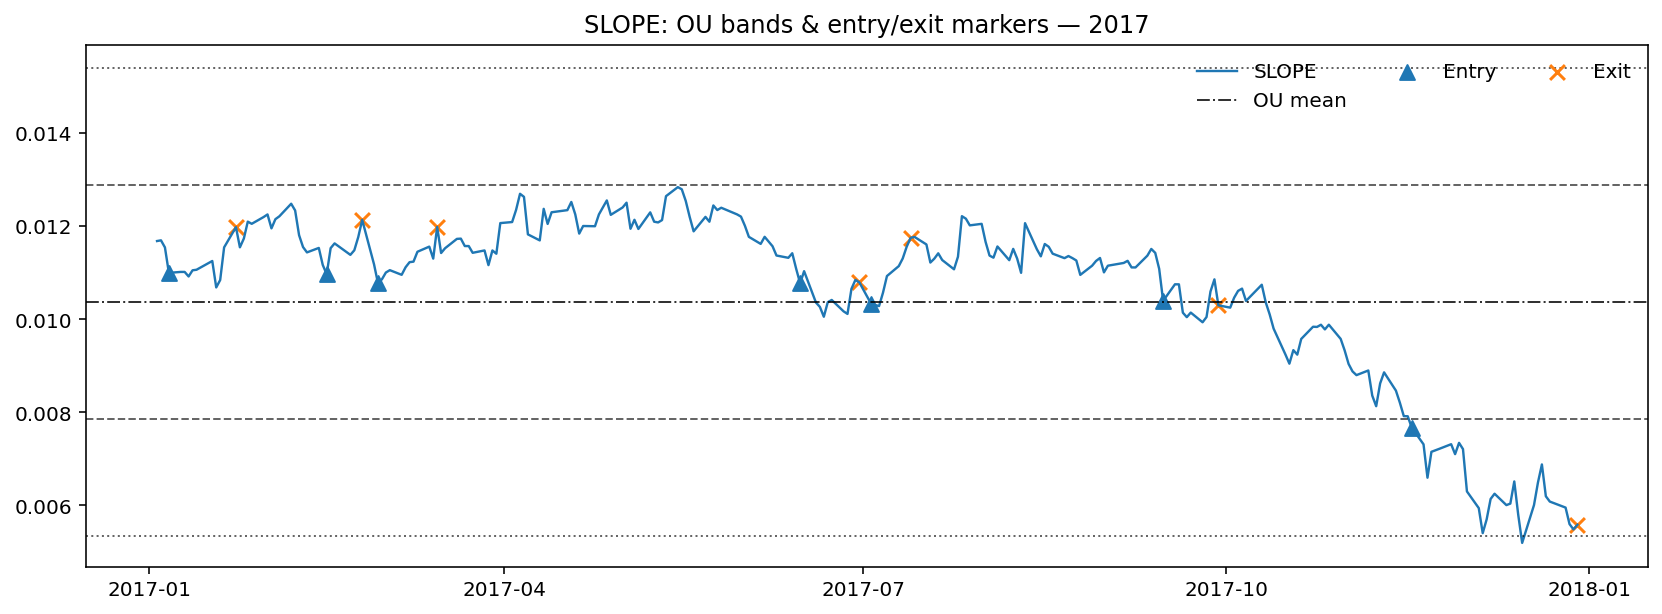

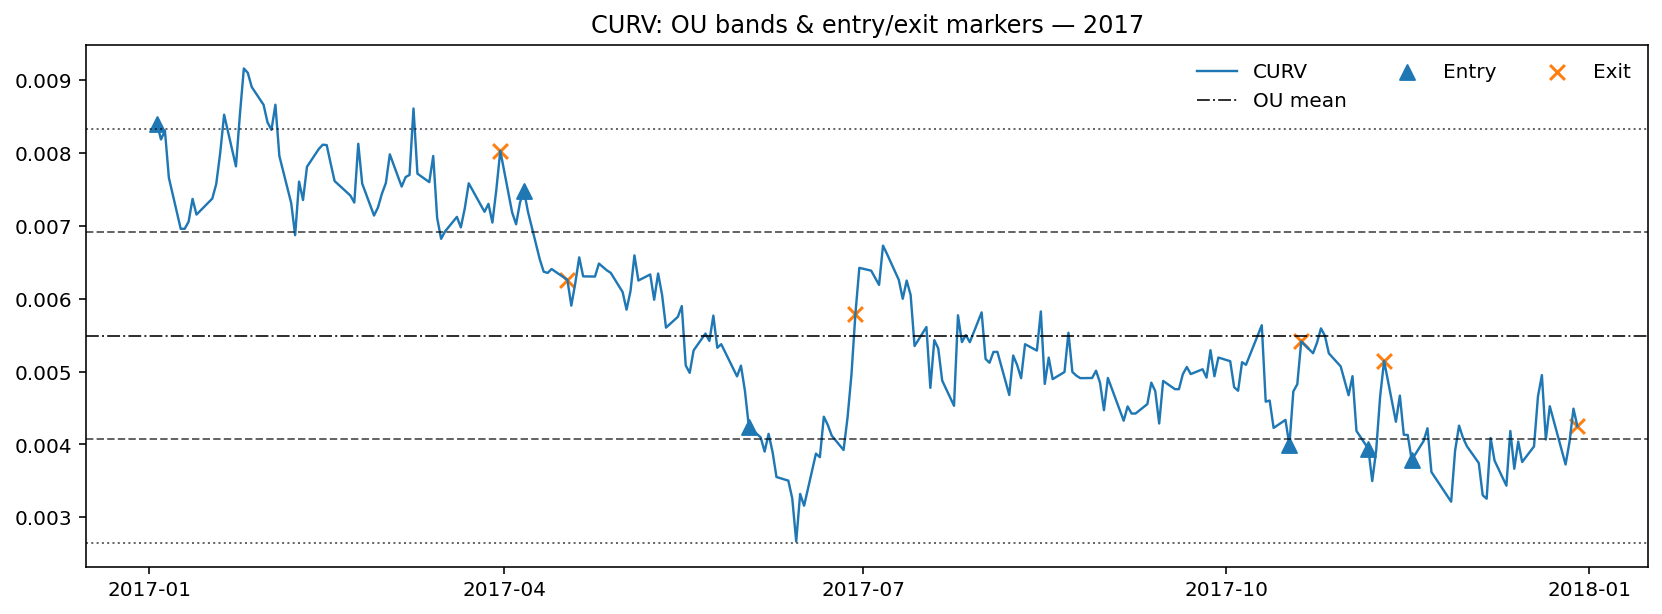

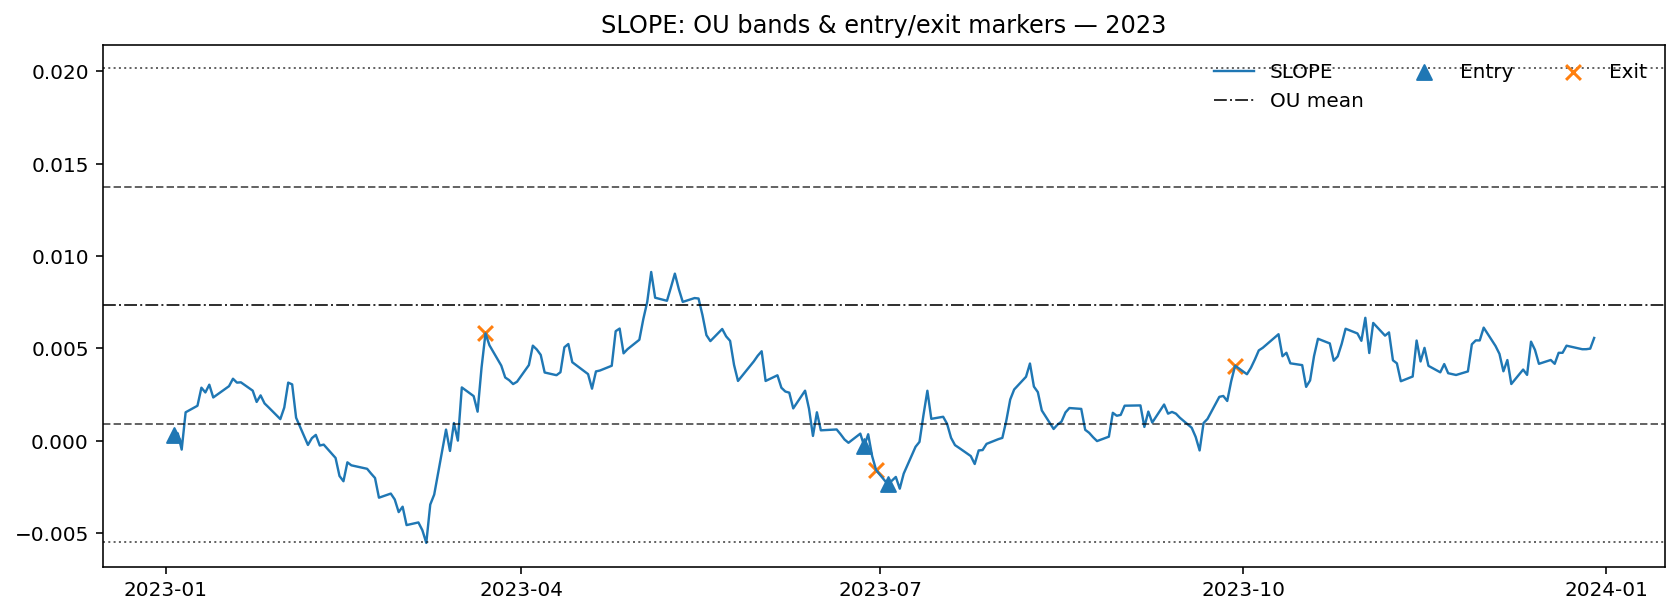

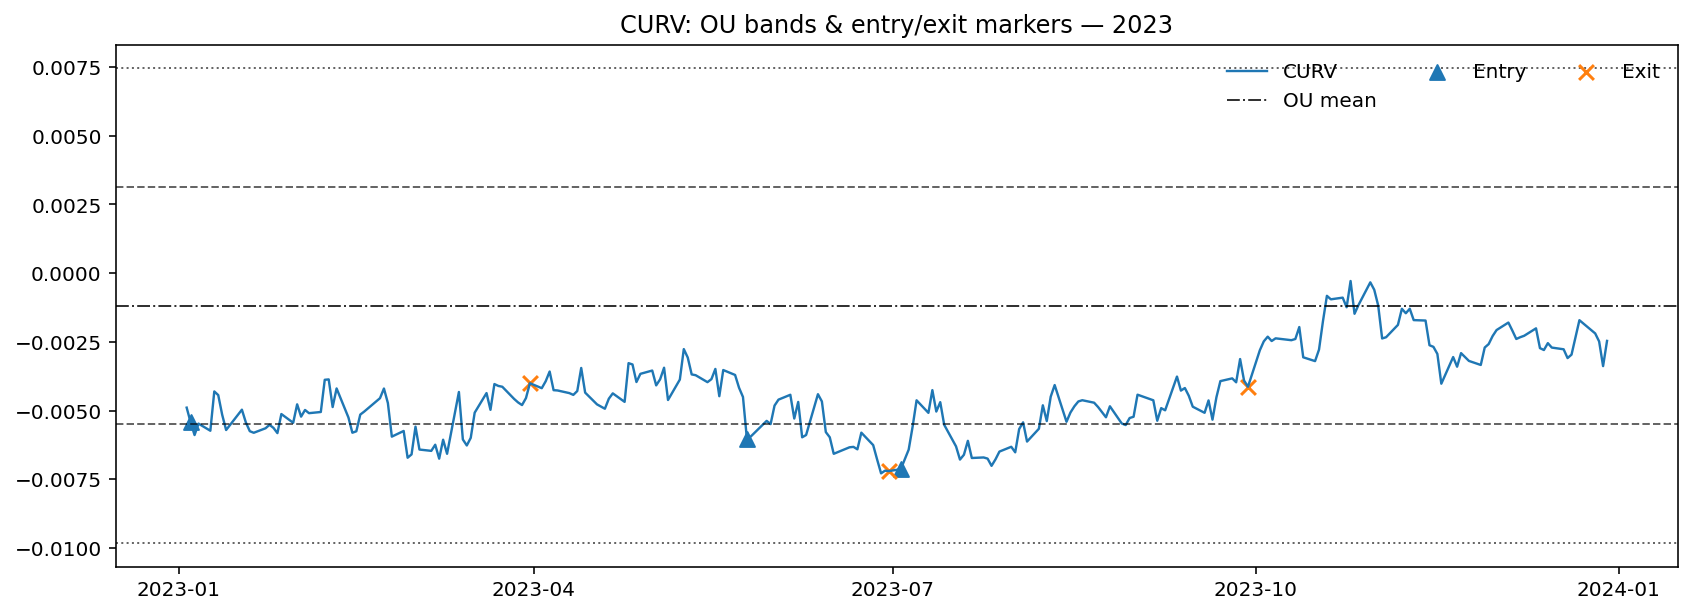

In [17]:
for y in YEARS: # Plot the entry/exit years
    for factor in ["SLOPE","CURV"]:
        plot_year(results[y], y, factor)



**Plot Summary**


| Year | Factor | Behavior | OU Fit | Result |
|------|---------|-----------|--------|--------|
| 2017 | SLOPE | Persistent flattening | Weak | False mean-reversion signals |
| 2017 | CURV | Downtrend, low reversion | Weak | Flat-to-negative |
| 2023 | SLOPE | Oscillatory around mean | Strong | Positive PnL, Sharpe $\sim 0.7$ |
| 2023 | CURV | Mild oscillations | Moderate | Low-vol, positive contribution |
